In [1]:
lr = 1e-3 
epoch = int(2e1) 
batch_size = 128
dim_z = 2 #20
layer_widths = [784, 500, 500, dim_z]

In [2]:
import numpy as np; np.random.seed(0)
import tensorflow.compat.v1 as tf; tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
x_train, x_test = x_train.astype(np.float32), x_test.astype(np.float32)

In [4]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 784)) # (?, 784)
dropout_rate = tf.placeholder(tf.float32, []) 

init_w = tf.keras.initializers.VarianceScaling(seed=0)
init_b = tf.keras.initializers.zeros()

w_shapes = []
previous = layer_widths[0] 
for i, layer_width in enumerate(layer_widths[1:]):
    w_shapes.append((previous, layer_width))
    previous = layer_width

for i, (pre, layer_width) in enumerate(w_shapes):
    w_name = f'w{i}_encoder'
    b_name = f'b{i}_encoder'
    if i!=2:
        w = tf.get_variable(w_name, (pre, layer_width), tf.float32, init_w)
        b = tf.get_variable(b_name, (layer_width,), tf.float32, init_b)
    elif i==2:
        w = tf.get_variable(w_name, (pre, 2*layer_width), tf.float32, init_w)
        b = tf.get_variable(b_name, (2*layer_width,), tf.float32, init_b)
    if i==0:
        x1 = tf.nn.elu(x @ w + b)
        x1 = tf.nn.dropout(x1, rate=dropout_rate)
    elif i==1:
        x1 = tf.nn.tanh(x1 @ w + b)
        x1 = tf.nn.dropout(x1, rate=dropout_rate)
    elif i==2:
        gaussian_params = x1 @ w + b 
        mu = gaussian_params[:, :dim_z]
        sigma = 1e-6 + tf.sigmoid(gaussian_params[:, dim_z:])
        
z = mu + sigma * tf.random_normal(tf.shape(mu))
        
for i, (pre, layer_width) in enumerate(w_shapes[::-1]):
    w_name = f'w{len(w_shapes)-1-i}_decoder'
    b_name = f'b{len(w_shapes)-1-i}_decoder'
    w = tf.get_variable(w_name, (layer_width, pre), tf.float32, init_w)
    b = tf.get_variable(b_name, (pre,), tf.float32, init_b)
    if i==0:
        x1 = tf.nn.tanh(z @ w + b)
        x1 = tf.nn.dropout(x1, rate=dropout_rate)
    elif i==1:
        x1 = tf.nn.elu(x1 @ w + b)
        x1 = tf.nn.dropout(x1, rate=dropout_rate)
    else:
        x_recon = tf.nn.sigmoid(x1 @ w + b)
        x_recon = tf.clip_by_value(x_recon, 1e-8, 1 - 1e-8)

l = - (x * tf.log(x_recon + 1e-8) + (1 - x) * tf.log(1 - x_recon + 1e-8))
l = tf.reduce_sum(l, 1)
loss_recon = tf.reduce_mean(l)

kl = 0.5*(tf.square(mu)+tf.square(sigma)-tf.log(1e-8+tf.square(sigma))-1)
kl = tf.reduce_sum(kl, 1)
loss_kl = tf.reduce_mean(kl)

loss = loss_recon + loss_kl

opt = tf.train.AdamOptimizer(lr)
train = opt.minimize(loss)

init = tf.global_variables_initializer()

In [5]:
with tf.Session() as sess:
    
    sess.run(init)
    
    loss_trace = []

    for i in range(epoch):
        
        idx = np.arange(x_train.shape[0])
        np.random.shuffle(idx)
        
        x_epoch = x_train[idx]
        
        for k in range(x_train.shape[0]//batch_size):
            
            if k==0:
                loss_temp = []
                loss_recon_temp = []
                loss_kl_temp = []
                
            x_batch = x_epoch[k*batch_size:(k+1)*batch_size]
            
            feed_dict = {x : x_batch, dropout_rate : 0.1}
            loss_run, loss_recon_run, loss_kl_run, _ = sess.run([loss, loss_recon, loss_kl, train], feed_dict=feed_dict)
            
            loss_temp.append(loss_run)
            loss_recon_temp.append(loss_recon_run) 
            loss_kl_temp.append(loss_kl_run) 
        
        loss_avg = np.array(loss_temp).mean()
        loss_recon_avg = np.array(loss_recon_temp).mean()
        loss_kl_avg = np.array(loss_kl_temp).mean()
        loss_trace.append(loss_avg)
        print(f'{i+1}/{epoch} loss {loss_avg}, loss_recon {loss_recon_avg}, loss_kl {loss_kl_avg}')
    
    feed_dict = {x : x_test, dropout_rate : 0.0}
    x_test_recon, x_test_z = sess.run([x_recon, z], 
                                           feed_dict=feed_dict)
    
    x_grid = np.linspace(-3., 3., 20)
    y_grid = np.linspace(-3., 3., 20)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    X_grid, Y_grid = X_grid.reshape((-1,1)), Y_grid.reshape((-1,1))
    z_grid = np.concatenate([X_grid, Y_grid], axis=1)
    
    feed_dict = {z : z_grid, dropout_rate : 0.0}
    latent_space_walk = sess.run(x_recon, feed_dict=feed_dict)

1/20 loss 195.80401611328125, loss_recon 190.05516052246094, loss_kl 5.7488555908203125
2/20 loss 173.19012451171875, loss_recon 167.36572265625, loss_kl 5.824389457702637
3/20 loss 165.9365997314453, loss_recon 160.29373168945312, loss_kl 5.6428632736206055
4/20 loss 161.82936096191406, loss_recon 156.12673950195312, loss_kl 5.702607154846191
5/20 loss 159.74176025390625, loss_recon 153.97727966308594, loss_kl 5.764474391937256
6/20 loss 158.10113525390625, loss_recon 152.2550048828125, loss_kl 5.846119403839111
7/20 loss 156.83790588378906, loss_recon 150.8813934326172, loss_kl 5.956505298614502
8/20 loss 155.61643981933594, loss_recon 149.58566284179688, loss_kl 6.030763626098633
9/20 loss 154.7570343017578, loss_recon 148.66744995117188, loss_kl 6.089569568634033
10/20 loss 153.87974548339844, loss_recon 147.720703125, loss_kl 6.159041881561279
11/20 loss 153.2467498779297, loss_recon 147.02804565429688, loss_kl 6.2187113761901855
12/20 loss 152.725830078125, loss_recon 146.4733886

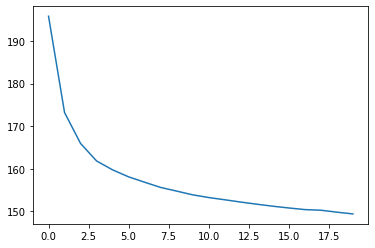

In [6]:
import matplotlib.pyplot as plt
plt.plot(loss_trace)
plt.show()

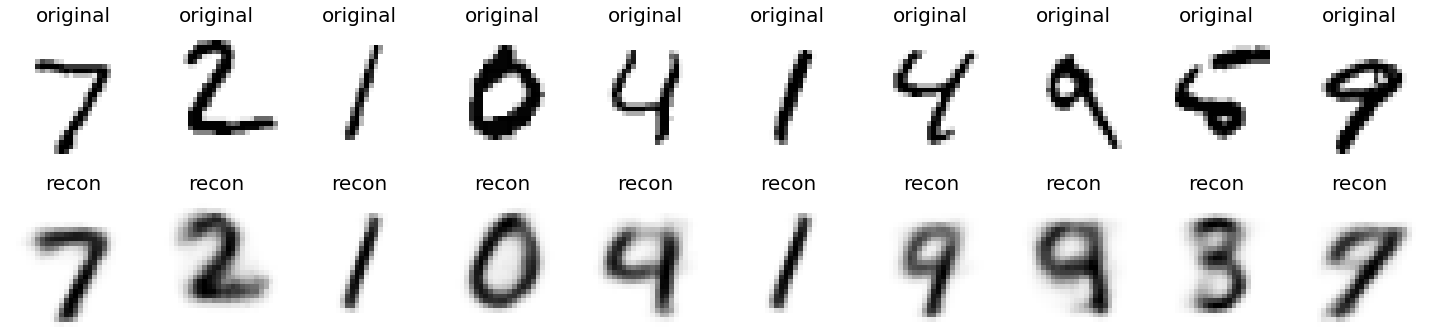

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20,5))

for i in range(2):
    for j in range(10):
        
        if i==0:
            img = x_test[j].reshape((28,28))
            title = 'original'
        else:
            img = x_test_recon[j].reshape((28,28))
            title = 'recon'
            
        axes[i, j].imshow(img, cmap='binary')
        axes[i, j].set_title(title, fontsize=20)
        axes[i, j].axis('off')
            
plt.tight_layout()

plt.show()

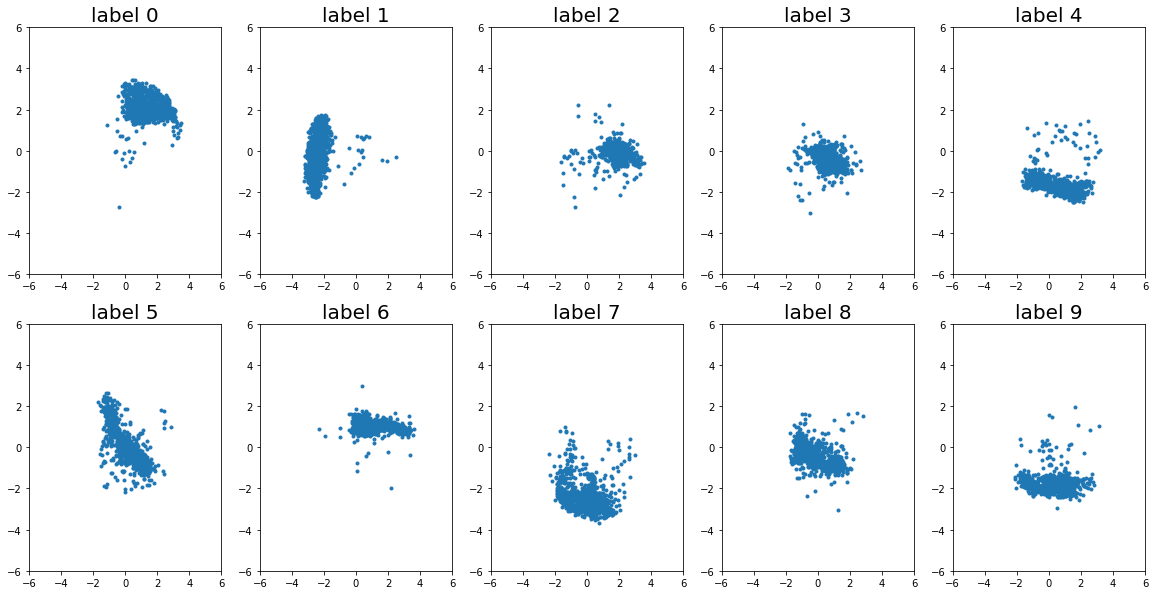

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))

for i in range(2):
    for j in range(5):
        
        k = i*5 + j
    
        x_fig = x_test_z[y_test==k][:,0]
        y_fig = x_test_z[y_test==k][:,1]
        axes[i, j].plot(x_fig, y_fig, '.')
        axes[i, j].set_title(f'label {k}', fontsize=20)
        axes[i, j].set_xlim([-6., 6.])
        axes[i, j].set_ylim([-6., 6.])
            
plt.show()

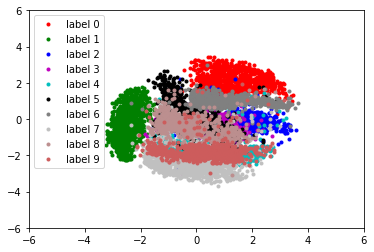

In [9]:
import matplotlib.pyplot as plt

colors = ['r','g','b','m','c','k','gray','silver','rosybrown','indianred']
for i in range(2):
    for j in range(5):
        
        k = i*5 + j
    
        x_fig = x_test_z[y_test==k][:,0]
        y_fig = x_test_z[y_test==k][:,1]
        plt.plot(x_fig, y_fig, '.', color=colors[k], label=f'label {k}')
        
plt.legend()
plt.xlim([-6., 6.])
plt.ylim([-6., 6.])
            
plt.show()

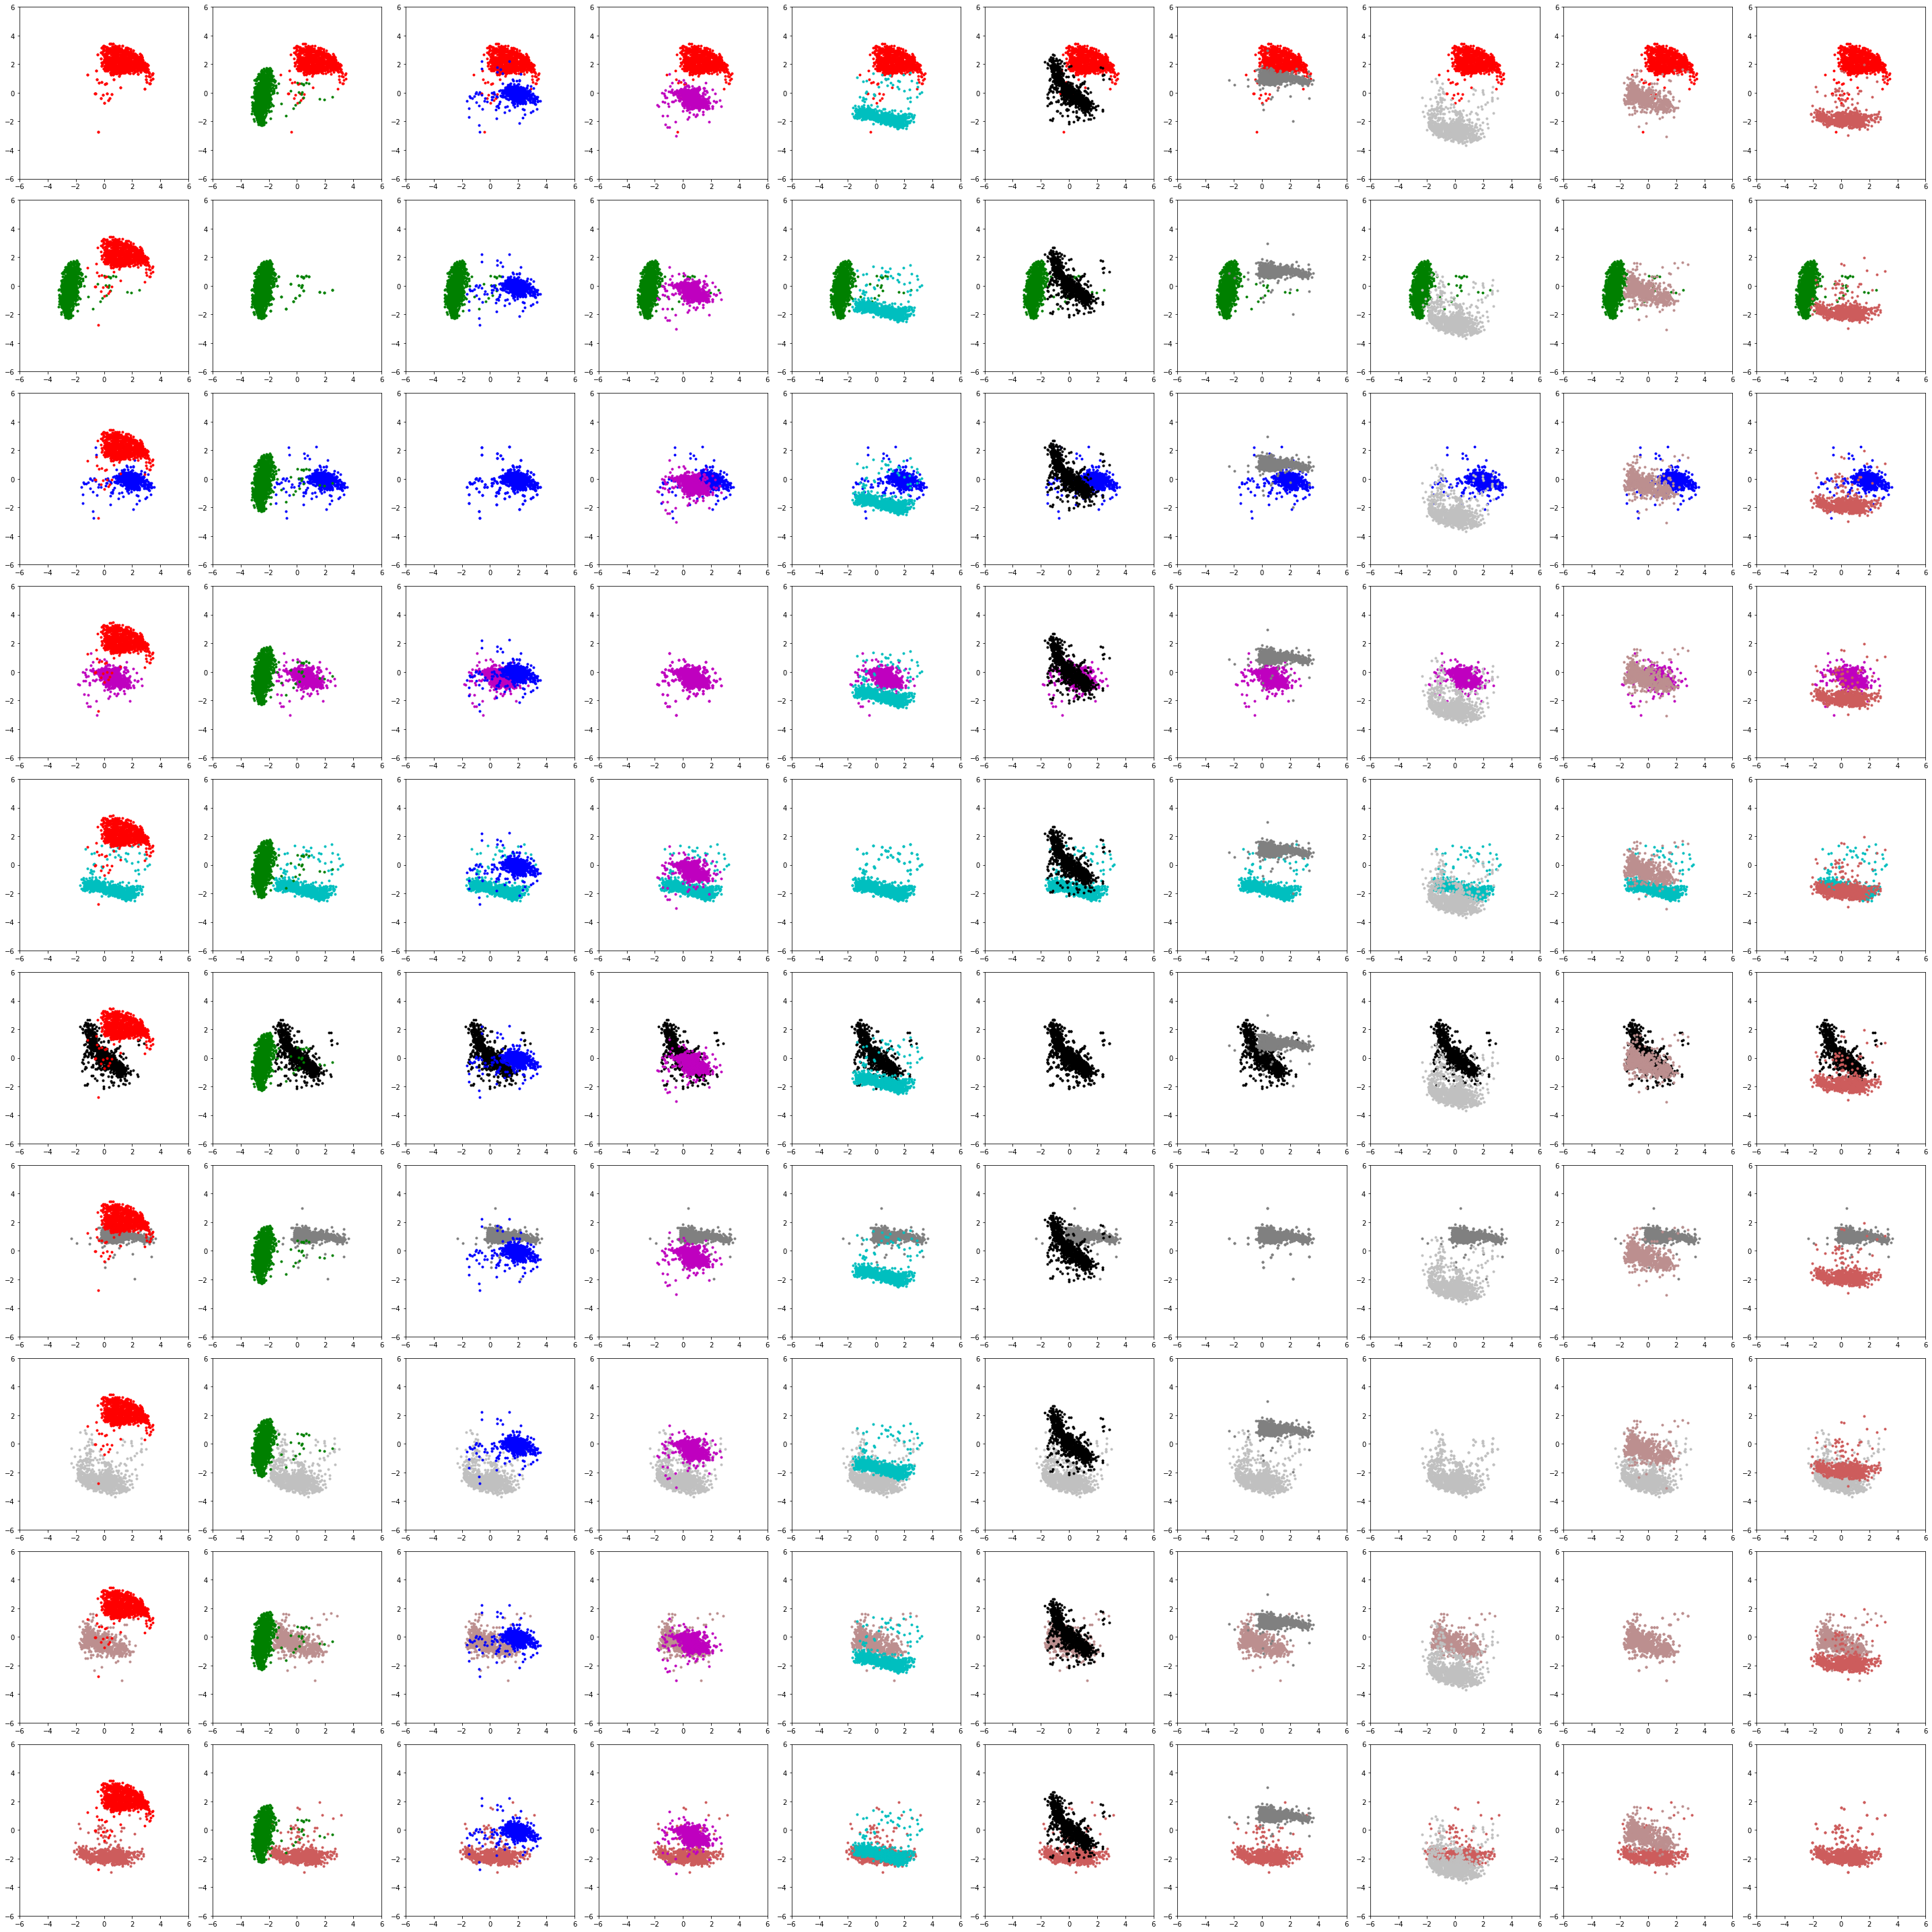

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(40,40))

colors = ['r','g','b','m','c','k','gray','silver','rosybrown','indianred']
for i in range(10):
    for j in range(10):
    
        x_fig = x_test_z[y_test==i][:,0]
        y_fig = x_test_z[y_test==i][:,1]
        axes[i, j].plot(x_fig, y_fig, '.', color=colors[i])
        
        x_fig = x_test_z[y_test==j][:,0]
        y_fig = x_test_z[y_test==j][:,1]
        axes[i, j].plot(x_fig, y_fig, '.', color=colors[j])

        axes[i, j].set_xlim([-6., 6.])
        axes[i, j].set_ylim([-6., 6.])

plt.tight_layout()
plt.show()

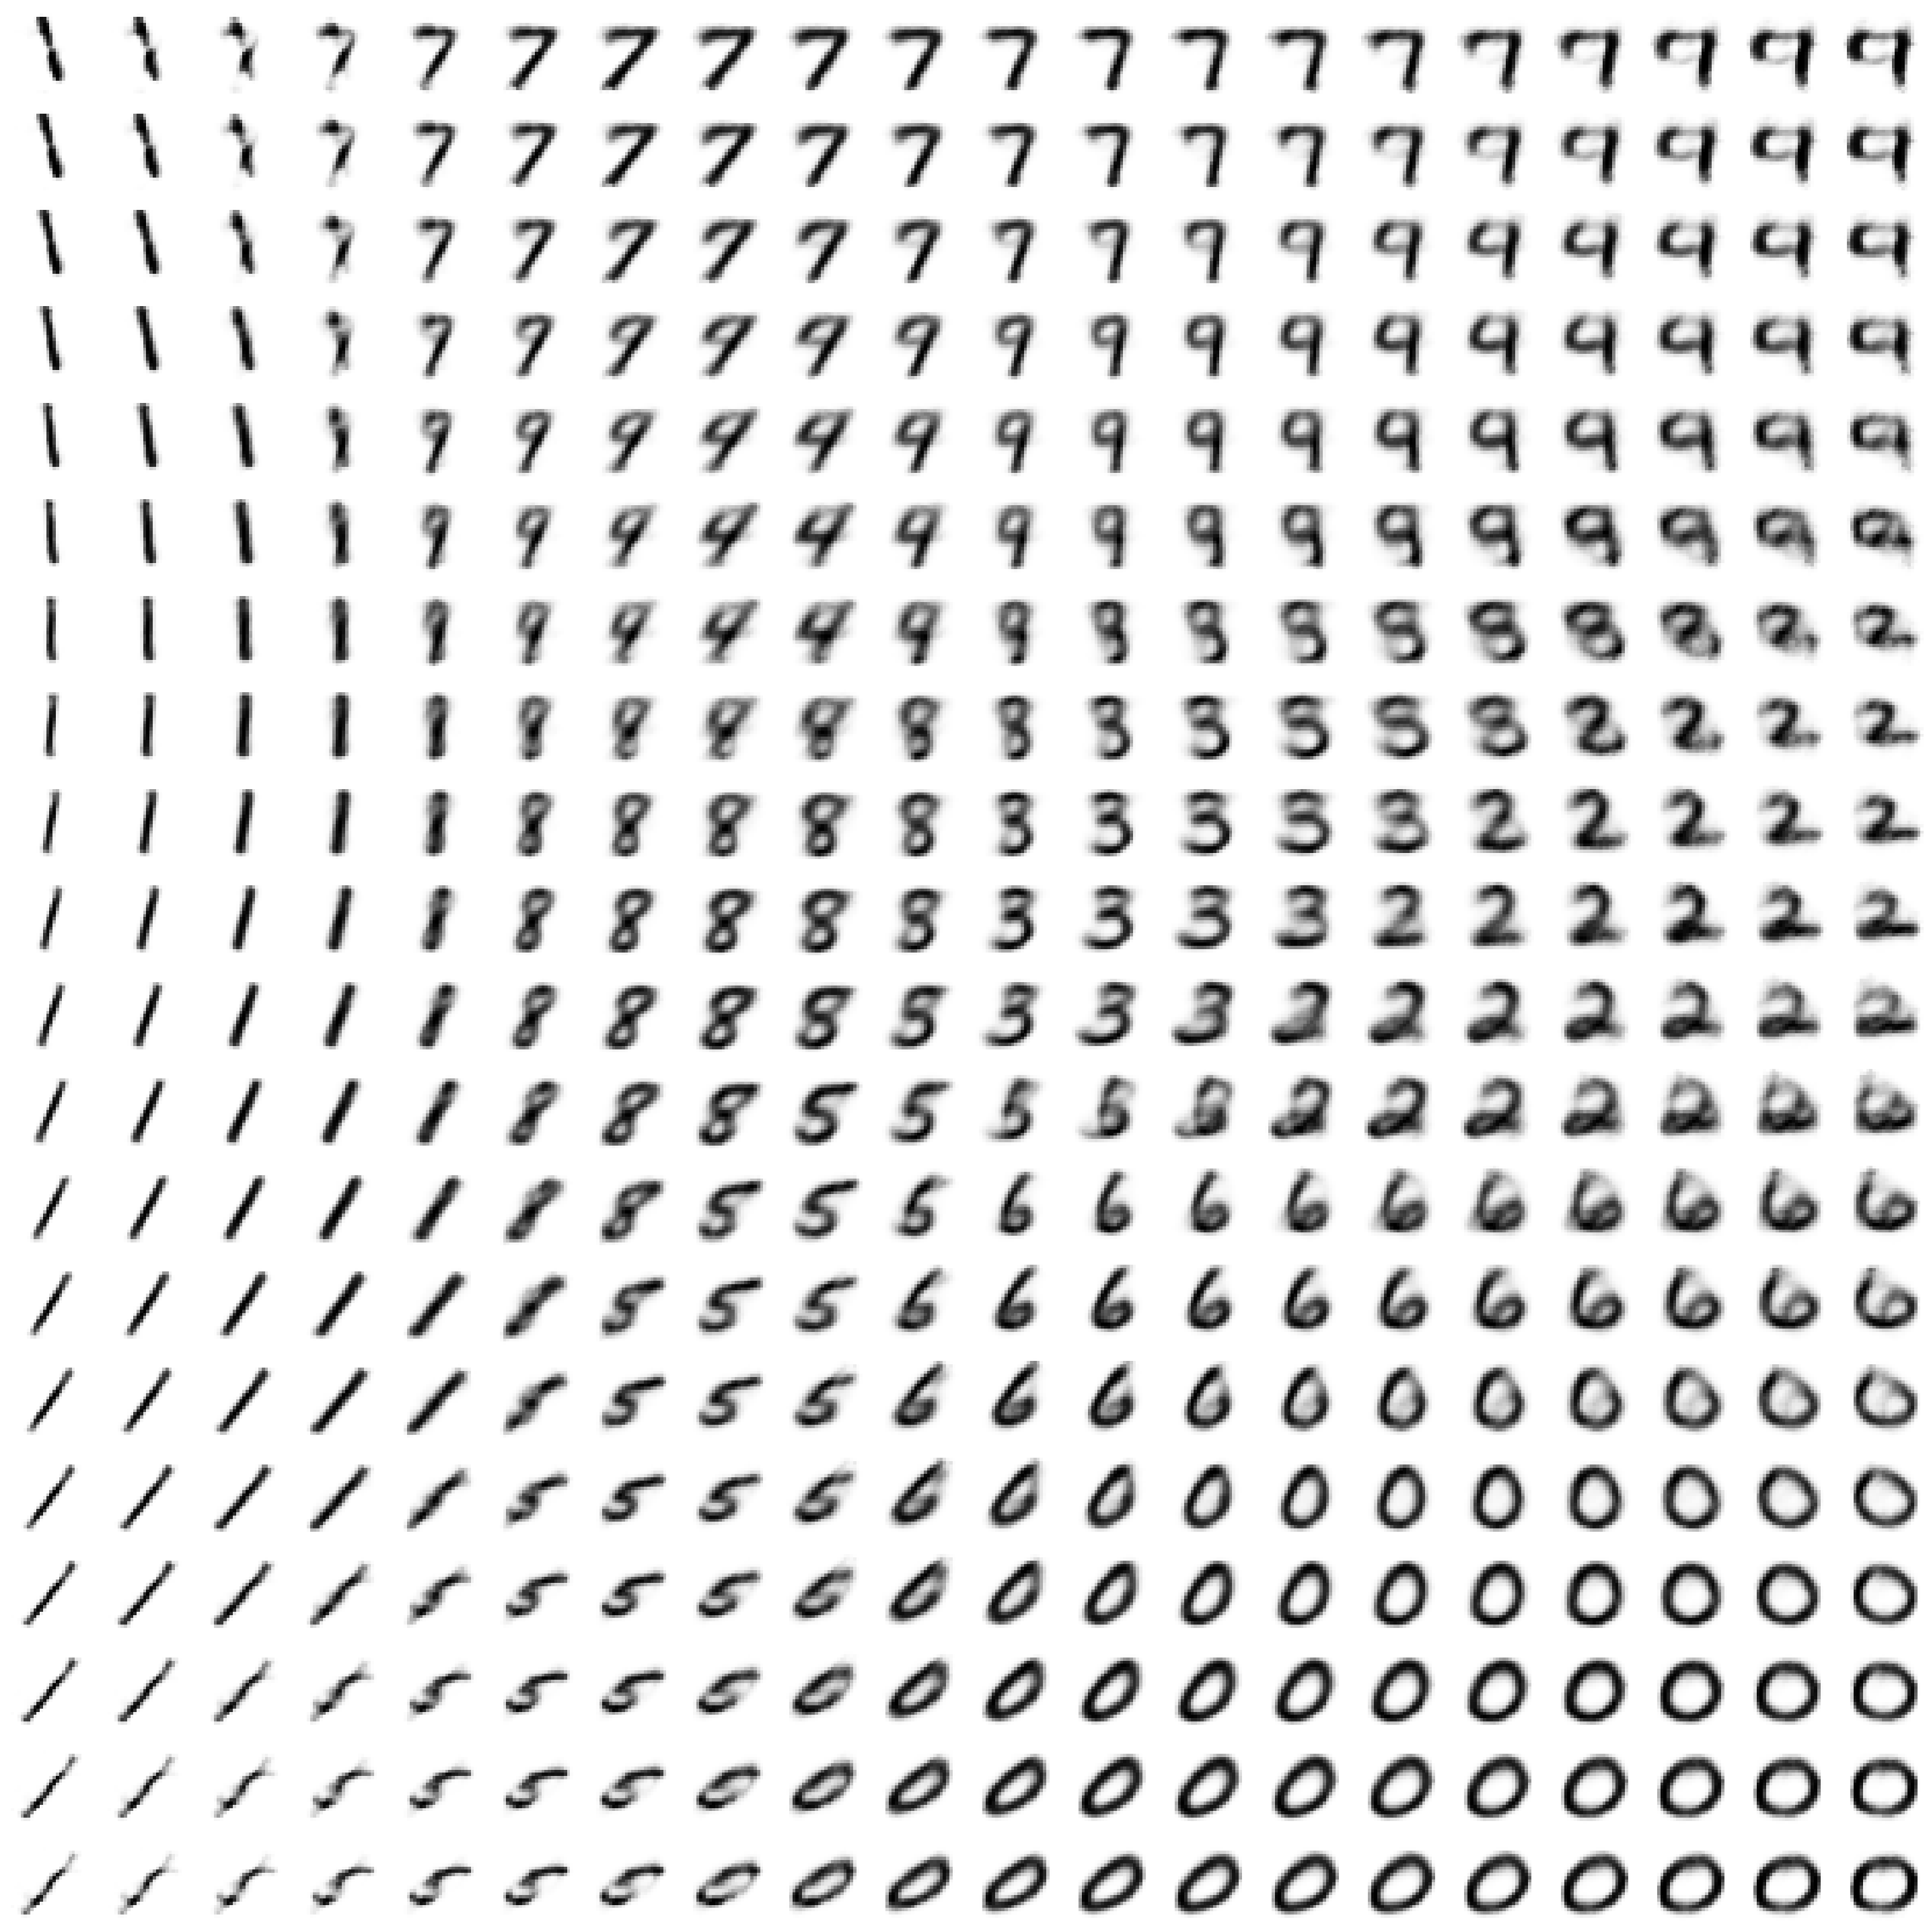

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=20, ncols=20, figsize=(40,40))

for i in range(20):
    for j in range(20):
        
        img = latent_space_walk[i*20+j].reshape((28,28))
            
        axes[i, j].imshow(img, cmap='binary')
        axes[i, j].axis('off')
            
plt.tight_layout()

plt.show()

# Reference

[hwalsuklee](https://github.com/hwalsuklee/tensorflow-mnist-VAE)